# QuickDraw-like doodle recognition !
You can check the game below: <br />
https://quickdraw.withgoogle.com/

Import all the usefull libraries

In [28]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import matplotlib.pyplot as plt

import os
import urllib.request

### Dowload the QuickDraw datasets <br />
You can see their datasets here: <br />
https://quickdraw.withgoogle.com/data

In [29]:
os.system('cls' if os.name == 'nt' else 'clear')
class_names = []

if (not os.path.exists("data")):
    os.mkdir("data")
f= open("mini_classes.txt","r")
classes = f.readlines()
f.close()
classes = [c.replace('\n','').replace(' ','_') for c in classes]
ind = 0
for c in classes:
    c_url = c.replace('_', '%20')
    print("Downloading " + c + " - [" + str(ind) + " /" + str(len(classes)) + "]")
    full_url = "https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/" + c_url + ".npy"
    if (not os.path.exists('data/' + c + ".npy")):
        urllib.request.urlretrieve(full_url, 'data/' + c + ".npy")
    ind += 1
print("Downloaded " + "[" + str(ind) + " /" + str(len(classes)) + "]")

Downloaded [10 /10]


### Process the Data

In [30]:
all_files = ['data/' + s for s in os.listdir("data")]
x_data = np.empty([0, 784])
y_labels = np.empty([0])

vfold_ratio=0.2
max_items_per_class=4000

for idx, file in enumerate(all_files):
    data = np.load(file)
    data = data[0:max_items_per_class, :]
    labels = np.full(data.shape[0], idx)

    x_data = np.concatenate((x_data, data), axis=0)
    y_labels = np.append(y_labels, labels)

    class_name, ext = os.path.splitext(os.path.basename(file))
    class_names.append(class_name)

data = None
labels = None

permutation = np.random.permutation(y_labels.shape[0])

x_data = x_data[permutation, :]
y_labels = y_labels[permutation]

vfold_size = int(x_data.shape[0]/100*(vfold_ratio*100))

x_test = x_data[0:vfold_size, :]
y_test = y_labels[0:vfold_size]

x_train = x_data[vfold_size:x_data.shape[0], :]
y_train = y_labels[vfold_size:x_data.shape[0]]

num_classes = len(os.listdir("data"))
image_size = 28

### Get an overview of the data

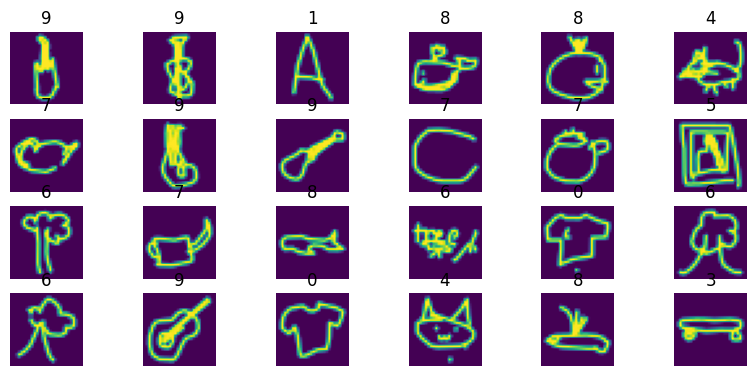

In [31]:
plt.figure(figsize=(10, 10))

for i in range(24):
    ax = plt.subplot(9, 6, i + 1)
    plt.imshow(x_train[i].reshape(28, 28))
    plt.title(int(y_train[i]))
    plt.axis("off")
plt.show()

### Shape the data to match the model format

In [32]:
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')

x_train /= 255.0
x_test /= 255.0

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

### Create your model

In [33]:
model = keras.Sequential()
model.add(layers.Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1))) # 32 filters, 5x5 kernel
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='sigmoid')) # 64 filters, 3x3 kernel
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(len(os.listdir("data")), activation='softmax'))

### Train your model

In [34]:
adam = tf.optimizers.Adam()
model.compile(loss='categorical_crossentropy',
            optimizer=adam,
            metrics=['top_k_categorical_accuracy'])
model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 256, verbose=2, epochs=3)
model.save('dr.h5')
model.save_weights('drWeight.h5')

Epoch 1/3
113/113 - 3s - loss: 1.4998 - top_k_categorical_accuracy: 0.8473 - val_loss: 0.7478 - val_top_k_categorical_accuracy: 0.9753 - 3s/epoch - 28ms/step
Epoch 2/3
113/113 - 3s - loss: 0.6522 - top_k_categorical_accuracy: 0.9786 - val_loss: 0.5685 - val_top_k_categorical_accuracy: 0.9819 - 3s/epoch - 26ms/step
Epoch 3/3
113/113 - 3s - loss: 0.5109 - top_k_categorical_accuracy: 0.9825 - val_loss: 0.4641 - val_top_k_categorical_accuracy: 0.9837 - 3s/epoch - 24ms/step


Your model has now been trained and generated a 'dr.h5' and 'drWeight.h5' files, these corresponds to your trained model and its reprocessed weights. <br /> You can now load the model to feed it the image you want to recognize.

Launch the paint program ("./paint" in your terminal) to test your ai.